<small>
We are going to run analysis on Twitter tweets to detect sentiment
Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api .
The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

It contains the following 6 fields:
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)

This data is loaded from Kaggle data set
https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

</small>

In [3]:
# --- Import libraries ---
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [7]:
# Since it is a zip file, let's load it as zip file. No need to unzip
df = pd.read_csv(
    "data/training.1600000.processed.noemoticon.csv",
    header=None,
    names=["target", "ids", "date", "flag", "user", "text"],
    encoding="ISO-8859-1",
    on_bad_lines="skip",  # skips problematic rows
    engine='python' # Use the python engine to handle potential parsing issues
)

In [10]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
# Keep only target and text
df = df[["target", "text"]]
# Convert target 0 = negative 4 = positive
df["target"] = df["target"].apply(lambda x: 0 if x == 0 else 1)

In [14]:
df['target'].value_counts()

,count
target,
0,800000
1,485133


In [20]:
# Use a preprocessing function
def clean_tweet(tweet):
    if tweet is None:  # Check if the tweet is None
        return ""      # Return an empty string if it is
    tweet = re.sub(r"http\S+", "", tweet)   # remove links
    tweet = re.sub(r"@\w+", "", tweet)      # remove mentions
    tweet = re.sub(r"#", "", tweet)         # remove hashtag symbol
    tweet = re.sub(r"[^A-Za-z\s]", "", tweet) # keep only letters
    tweet = tweet.lower()
    return tweet.strip()

In [22]:
# Let's clean the text
df["clean_text"] = df["text"].apply(clean_tweet)

In [23]:
# Do train test split
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["target"], test_size=0.2, random_state=42)

In [24]:
# -- Convert text to numeric functions
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [25]:
# train model on logistic regression
model = LogisticRegression()
model.fit(X_train_vec, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
# Evaluate
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85    159950
           1       0.77      0.71      0.74     97077

    accuracy                           0.81    257027
   macro avg       0.80      0.79      0.79    257027
weighted avg       0.81      0.81      0.81    257027

Accuracy: 0.8094752691351492


<Figure size 600x600 with 0 Axes>

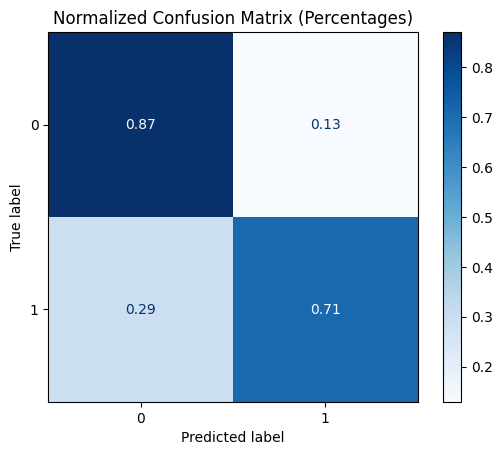

In [30]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)

# Convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=model.classes_)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format=".2f")  # show values as decimals (e.g., 0.85)
plt.title("Normalized Confusion Matrix (Percentages)")
plt.show()